In [1]:
#Data Diri
print ('Nama         : Murwanjani Tejo Riyono')
print ('Kelas        : MLFE M1')
print ('Proyek Akhir : Image Classification Model Deployment')

Nama         : Murwanjani Tejo Riyono
Kelas        : MLFE M1
Proyek Akhir : Image Classification Model Deployment


In [2]:
#Import Library
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#Confirm kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"m120t6084","key":"e84a806a040113a8065868b02fd3c103"}'}

In [4]:
#Install kaggle dan download dataset dari kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alessiocorrado99/animals10

100% 586M/586M [00:04<00:00, 139MB/s]



In [5]:
#Import Library untuk zipfile,os dan shutil
import zipfile,os,shutil
local_zip = '/content/animals10.zip' #Variable local_zip berisi direktori lokasi file zip disimpan

#Proses ekstrak file zip
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/animals10')
zip_ref.close()

base_dir = '/content/animals10/raw-img' #Memasukkan isi /content/animals10/raw-img kedalam var base_dir

In [6]:
#Melihat jumlah folder dari file
len(os.listdir(base_dir))

10

In [7]:
#Melihat isi dari base_dir
os.listdir(base_dir)

['scoiattolo',
 'farfalla',
 'mucca',
 'gallina',
 'pecora',
 'elefante',
 'ragno',
 'cavallo',
 'gatto',
 'cane']

In [8]:
#Rubah nama folder
!mv /content/animals10/raw-img/cane /content/animals10/raw-img/dog
!mv /content/animals10/raw-img/cavallo /content/animals10/raw-img/horse
!mv /content/animals10/raw-img/elefante /content/animals10/raw-img/elephant
!mv /content/animals10/raw-img/farfalla /content/animals10/raw-img/butterfly
!mv /content/animals10/raw-img/gallina /content/animals10/raw-img/chicken
!mv /content/animals10/raw-img/gatto /content/animals10/raw-img/cat
!mv /content/animals10/raw-img/mucca /content/animals10/raw-img/cow
!mv /content/animals10/raw-img/pecora /content/animals10/raw-img/sheep
!mv /content/animals10/raw-img/ragno /content/animals10/raw-img/spider
!mv /content/animals10/raw-img/scoiattolo /content/animals10/raw-img/squirrel

In [9]:
#Tampilkan isi yang baru
os.listdir(base_dir)

['spider',
 'elephant',
 'butterfly',
 'cat',
 'sheep',
 'cow',
 'dog',
 'horse',
 'squirrel',
 'chicken']

In [10]:
#Membuang folder yang tidak dibutuhkan
ignore_base_dir = ['cat', 'sheep', 'elephant', 'cow', 'squirrel', 'spider']

for x in ignore_base_dir:
  path = os.path.join(base_dir, x)
  shutil.rmtree(path)

In [11]:
contents=os.listdir(base_dir)
print(contents)

['butterfly', 'dog', 'horse', 'chicken']


In [12]:
from PIL import Image
total = 0

for x in contents:
  dir = os.path.join(base_dir, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal Dataset Digunakan :', total)

butterfly: 2112
- (300, 200)
- (640, 424)
- (179, 194)
- (300, 226)
---------------
dog: 4863
- (300, 300)
- (226, 300)
- (300, 169)
- (300, 200)
---------------
horse: 2623
- (300, 226)
- (300, 252)
- (300, 221)
- (300, 233)
---------------
chicken: 3098
- (300, 275)
- (291, 300)
- (300, 225)
- (300, 257)
---------------

Total Dataset Digunakan : 12696


In [13]:
#Proses pembuatan generator train dan val
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range = 0.2,
    zoom_range=0.3,
    validation_split=0.2,
    fill_mode = 'nearest')

In [14]:
data_train = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='training')

data_val = datagen.flow_from_directory(
    base_dir, 
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='validation')

Found 10159 images belonging to 4 classes.
Found 2537 images belonging to 4 classes.


In [15]:
#Model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [16]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.optimizers.Adam(),
              metrics = ['accuracy'])

In [17]:
#Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.92 and logs.get('val_accuracy')>=0.92):
      print("\nAkurasi telah mencapai 92%!")
      self.model.stop_training = True

callbacks = myCallback()

In [18]:
#Proses Training
history = model.fit(data_train, 
                    epochs = 90, 
                    steps_per_epoch = data_train.samples // 128,
                    validation_data = data_val,
                    validation_steps = data_val.samples // 128,
                    verbose = 2,
                    callbacks = [callbacks])

Epoch 1/90
79/79 - 120s - loss: 1.1810 - accuracy: 0.4714 - val_loss: 1.0718 - val_accuracy: 0.5493
Epoch 2/90
79/79 - 83s - loss: 0.9257 - accuracy: 0.6220 - val_loss: 0.8042 - val_accuracy: 0.6879
Epoch 3/90
79/79 - 83s - loss: 0.7298 - accuracy: 0.7147 - val_loss: 0.7421 - val_accuracy: 0.7060
Epoch 4/90
79/79 - 85s - loss: 0.6506 - accuracy: 0.7526 - val_loss: 0.7424 - val_accuracy: 0.7171
Epoch 5/90
79/79 - 85s - loss: 0.6153 - accuracy: 0.7665 - val_loss: 0.5888 - val_accuracy: 0.7812
Epoch 6/90
79/79 - 86s - loss: 0.5356 - accuracy: 0.7991 - val_loss: 0.5182 - val_accuracy: 0.8039
Epoch 7/90
79/79 - 84s - loss: 0.5187 - accuracy: 0.8087 - val_loss: 0.5373 - val_accuracy: 0.8022
Epoch 8/90
79/79 - 83s - loss: 0.5029 - accuracy: 0.8113 - val_loss: 0.4811 - val_accuracy: 0.8306
Epoch 9/90
79/79 - 84s - loss: 0.4667 - accuracy: 0.8297 - val_loss: 0.5170 - val_accuracy: 0.8002
Epoch 10/90
79/79 - 84s - loss: 0.4629 - accuracy: 0.8255 - val_loss: 0.4331 - val_accuracy: 0.8466
Epoch 11

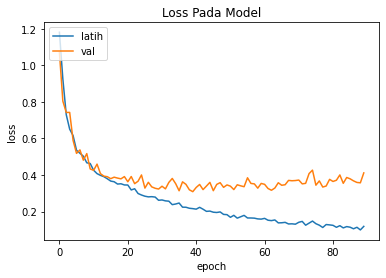

In [19]:
#Plot loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Pada Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['latih', 'val'], loc='upper left')
plt.show()

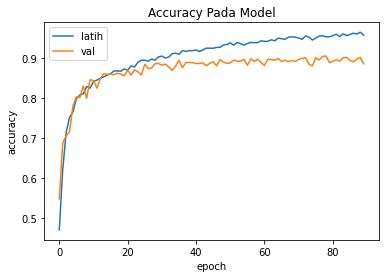

In [20]:
#Plot Akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Pada Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['latih', 'val'], loc='upper left')
plt.show()

In [21]:
#Convert file ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3d7u_ag5/assets
